# Convolutional Sentiment Classifier

In this notebook, we build a *convolutional* neural net to classify IMDB movie reviews by their sentiment.

#### Load dependencies

In [1]:
import keras
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding
from keras.layers import SpatialDropout1D, Conv1D, GlobalMaxPooling1D # new! 
from keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import roc_auc_score 
import matplotlib.pyplot as plt 
%matplotlib inline

Using TensorFlow backend.


#### Set hyperparameters

In [2]:
# output directory name:
output_dir = 'model_output/conv'

# training:
epochs = 4
batch_size = 128

# vector-space embedding: 
n_dim = 64
n_unique_words = 5000 
max_review_length = 400
pad_type = trunc_type = 'pre'
drop_embed = 0.2 # new!

# convolutional layer architecture:
n_conv = 256 # filters, a.k.a. kernels
k_conv = 3 # kernel length

# dense layer architecture: 
n_dense = 256
dropout = 0.2

#### Load data

In [3]:
(x_train, y_train), (x_valid, y_valid) = imdb.load_data(num_words=n_unique_words) # removed n_words_to_skip

#### Preprocess data

In [4]:
x_train = pad_sequences(x_train, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)
x_valid = pad_sequences(x_valid, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)

#### Design neural network architecture

In [5]:
model = Sequential()
model.add(Embedding(n_unique_words, n_dim, input_length=max_review_length)) 
model.add(SpatialDropout1D(drop_embed))
model.add(Conv1D(n_conv, k_conv, activation='relu'))
# model.add(Conv1D(n_conv, k_conv, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(n_dense, activation='relu'))
model.add(Dropout(dropout))
model.add(Dense(1, activation='sigmoid'))

In [6]:
model.summary() 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 400, 64)           320000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 400, 64)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 398, 256)          49408     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total para

#### Configure model

In [7]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [8]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#### Train!

In [9]:
# 89.1% validation accuracy in epoch 2
# ...with second convolutional layer is essentially the same at 89.0%
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_valid, y_valid), callbacks=[modelcheckpoint])

Train on 25000 samples, validate on 25000 samples
Epoch 1/4
25000/25000 [==============================] - 264s 11ms/step - loss: 0.4892 - acc: 0.7461 - val_loss: 0.2970 - val_acc: 0.8743
Epoch 2/4
25000/25000 [==============================] - 261s 10ms/step - loss: 0.2534 - acc: 0.8964 - val_loss: 0.2627 - val_acc: 0.8903
Epoch 3/4
25000/25000 [==============================] - 257s 10ms/step - loss: 0.1718 - acc: 0.9339 - val_loss: 0.2578 - val_acc: 0.8954
Epoch 4/4
25000/25000 [==============================] - 312s 12ms/step - loss: 0.1149 - acc: 0.9601 - val_loss: 0.2828 - val_acc: 0.8920


#### Evaluate

In [10]:
model.load_weights(output_dir+"/weights.01.hdf5") # zero-indexed

In [11]:
y_hat = model.predict_proba(x_valid)

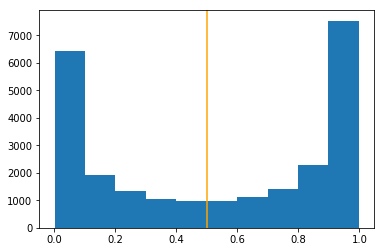

In [12]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [13]:
"{:0.2f}".format(roc_auc_score(y_valid, y_hat)*100.0)

'94.79'